# Usage Guide

Note: Runtime -> Change runtime type -> T4 GPU for faster training.

0. Make a copy of this notebook.
1. Perform your data processing locally and upload the folder containing spectrograms to your Google Drive. Optionally upload a folder containing augmented spectrograms to your Google Drive as well. I suggest you create a RespiraCheck folder in your drive with the directory 'cough_data', in which you place the spectrogram folder(s).
2. Mount your Google Drive with the code block below. Then run the Helper Functions block which contains code for DataPipeline (modified so that it does not depend on processors) and ModelHandler.
3. In the Dataset tab, change the paths to fit your file structure and then run the code block. A tensor dataset (two if you have augmented data) should be created as a result of this; these are the .pt files. **If you want to regenerate/switch the data you are using, make sure to delete the tensor dataset file first!**
4. In the Model tab, you can modify the model architecture.
5. In the Training tab, you can modfiy the hyperparameters and train your model. Feel free to modify other parts of the code as well, if you want.
6. Good luck!



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Collapse and run Helper Functions (includes imports, datapipeline, modelhandler, and model code)

# Helper Functions

In [ ]:
import torchvision.models as models
import os
from PIL import Image
import numpy as np
import collections
from datetime import datetime
import time
import librosa
import sys
import matplotlib.pyplot as plt
import pandas as pd
import io
from tqdm import tqdm
import librosa
import librosa.display
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter
import json
import librosa.feature
from contextlib import nullcontext
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision import transforms

!pip install noisereduce
import noisereduce as nr
!pip install pydub
from pydub import AudioSegment, silence
from pydub.silence import detect_nonsilent
!pip install torchmetrics
import torchmetrics

## DataPipeline

In [ ]:
"""Dataset Processing Module.

This module provides the `DataPipeline` class for handling dataset operations,
including loading, processing, and splitting datasets for training and inference.

"""
import os
from PIL import Image

import torch
from torch.utils.data import random_split, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision import transforms
from pydub import AudioSegment
import io


class DataPipeline:
    """Processes datasets, including loading, splitting, and preparing for inference.

    This class provides methods for loading datasets, processing them for training,
    and preparing single instances for inference.

    Attributes:
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include for validation.
        audio_processor: AudioProcessor instance for handling audio processing.
        image_processor: ImageProcessor instance for handling spectrogram or extracted features processing.
    """

    def __init__(self, test_size: float, val_size: float):
        """Initializes the DatasetProcessor.

        Args:
            data_path (str): Path to the dataset file.
            test_size (float): Proportion of the dataset to include in the test split.
        """
        self.test_size = test_size
        self.val_size = val_size

    def load_and_save_dataset(self, image_dir_path: str, tensor_path: str) -> TensorDataset:
        """
        Loads the dataset from the specified file path and saves it, returns TensorDataset.
        image_path (str): path to the folder containing the images
        tensor_path (str): path to save the TensorDataset
        """
        tensors = []
        labels = []

        for label_folder, label_value in zip(["positive", "negative"], [1, 0]):
            output_dir = os.path.join(image_dir_path, label_folder)
            print(f"Processing folder: {output_dir}")

            if not os.path.exists(output_dir):
                print(f"Folder not found: {output_dir}. Skipping...")
                continue
            for image_name in os.listdir(output_dir):
                if image_name.endswith(".png"):
                    image_path = os.path.join(output_dir, image_name)
                    image_tensor = self.image_to_tensor(image_path)

                    tensors.append(image_tensor)
                    labels.append(label_value)
                else:
                    print(f"Skipping non-image file: {image_name}")

        # Tensor of all features (N x D) - N is number of samples (377), D is feature dimension (3,224,224)
        X = torch.stack(tensors)
        # Tensor of all labels (N x 1) - 377x1
        y = torch.tensor(labels, dtype=torch.long)

        dataset = TensorDataset(X, y)
        if tensor_path:
            torch.save(dataset, tensor_path)
            print(f"Dataset saved at {tensor_path}")

        return dataset


    def image_to_tensor(self, image_path: str) -> torch.Tensor:
        """Converts a spectrogram image to a PyTorch tensor.

        Args:
            image_path (str): Path to the spectrogram image file.

        Returns:
            torch.Tensor: The PyTorch tensor representation of the image.
        """
        transform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to ResNet18 input size
            transforms.ToTensor(),  # Convert image to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ResNet18
        ])

        image = Image.open(image_path).convert("RGB") # Convert from RGBA to RGB
        tensor_image = transform(image)

        return tensor_image  # shape will be 3, 224, 224

    def create_dataloaders(self,
                           batch_size,
                           spectro_dir_path,
                           dataset_path,
                           upsample = True,
                           aug_spectro_dir_path = None,
                           aug_dataset_path = None) -> tuple[DataLoader, DataLoader, DataLoader]:
        """Splits the dataset into training and test sets.

        The first time you train on the dataset, this function will process the images into tensors
        and save them to the location `dataset_path` specifically for the tensor dataset.
        In subsequent runs, this function will detect that the augmented tensor data has already been created
        and will skip image processing.

        The first time you are training on augmented data, provide the path to the augmented spectrograms
        and the path you would like to save the augmented tensor data to.
        This function will convert the spectrograms into tensors and save them to the indicated location.
        In subsequent runs, this function will detect that the augmented tensor data has already been created
        and will skip image processing.

        Args:
            batch_size (int): The batch size for the DataLoader.
            spectro_dir_path (str | None): Path to the spectrogram directory.
            dataset_path (str | None): Path to the TensorDataset file (created by this function)
            upsample (bool): Whether to upsample the positive class.
            aug_spectro_dir_path (str | None): Path to the augmented spectrogram directory.
            aug_dataset_path (str | None): Path to the augmented tensor dataset file (created by this function).

        Returns:
            tuple: (train_df, test_df) - The training and testing DataFrames.
        """
        if os.path.exists(dataset_path):  # Tensor dataset created already
            print(f"Loading dataset from {dataset_path}")
            dataset = torch.load(dataset_path, weights_only=False)
        else:  # Folder is empty or does not exist
            print(f"Processing and loading dataset from {spectro_dir_path}")
            dataset = self.load_and_save_dataset(image_dir_path=spectro_dir_path,
                                                 tensor_path=dataset_path)

        if aug_dataset_path is not None:
            if os.path.exists(aug_dataset_path):  # Augmented tensor dataset created already
                print(f"Loading augmented dataset from {aug_dataset_path}")
                aug_dataset = torch.load(aug_dataset_path, weights_only=False)
            elif aug_spectro_dir_path:
                print(f"Adding augmented spectrogram data to training dataset from {aug_spectro_dir_path}")
                aug_dataset = self.load_and_save_dataset(image_dir_path=aug_spectro_dir_path,
                                                         tensor_path=aug_dataset_path)
            else:
                print("No augmented spectrogram data found. Proceeding without augmented data...")
                aug_dataset = TensorDataset(torch.tensor([]), torch.tensor([]))
        else:
            print("No augmented dataset path provided. Proceeding without augmented data...")
            aug_dataset = TensorDataset(torch.tensor([]), torch.tensor([]))

        # Calculate sizes
        test_size = round(self.test_size * len(dataset))
        val_size = round(self.val_size * len(dataset))
        train_size = round(len(dataset) - test_size - val_size)  # Remaining for training

        # Perform split
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
        print(f"Train dataset size: {len(train_dataset)}")
        print(f"Augmented dataset size: {len(aug_dataset)}")

        # Combine train and augmented datasets
        train_dataset = torch.utils.data.ConcatDataset([train_dataset, aug_dataset])
        print(f"Train + augmented dataset size: {len(train_dataset)}")

        # Count positive and negative samples
        train_counts = self.count_labels(train_dataset)
        print(f"Training: {train_counts[1]} positive | {train_counts[0]} negative")
        val_counts = self.count_labels(val_dataset)
        print(f"Validation: {val_counts[1]} positive | {val_counts[0]} negative")
        test_counts = self.count_labels(test_dataset)
        print(f"Testing: {test_counts[1]} positive | {test_counts[0]} negative")

        # Upsample positive class
        if upsample:
            print("Upsampling data")
            labels = [label.item() for _, label in train_dataset]
            weights = torch.where(torch.tensor(labels) == 0, 1 / train_counts[0], 1 / train_counts[1])
            print(f"Negative Weight: {1 / train_counts[0]} | Positive Weight: {1 / train_counts[1]}")

            wr_sampler = WeightedRandomSampler(weights, int(len(train_dataset) * 1.5))

            train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=wr_sampler)

        else:
            print("No upsampling")
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Create DataLoaders
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Count labels in train_loader
        train_counts = {}
        for _, labels in train_loader:
            for label in labels:
                train_counts[label.item()] = train_counts.get(label.item(), 0) + 1

        # Reduce memory footprint (only matters on JupyterNotebook)
        dataset, train_dataset, val_dataset, test_dataset = None, None, None, None

        print("Done.")

        return train_loader, val_loader, test_loader

    def count_labels(self, dataset):
        """Counts the number of positive and negative labels in the dataset.

        Args:
            dataset (torch.utils.data.Dataset): The dataset to count labels from.

        Returns:
            dict: A dictionary containing the counts of positive and negative labels.
        """
        labels = [label.item() for _, label in dataset]
        counts = {0: 0, 1: 0}
        for label in labels:
            counts[label] = counts[label] + 1
        return counts

## ModelHandler

In [ ]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as opt
import torchmetrics

class ModelHandler:
    """Handles the model training, evaluation, and inference pipeline.

    Attributes:
        device (torch.device): The device on which the model is executed (e.g., 'cpu' or 'cuda').
        models_dir: Path to where .pth models should be saved.
    """

    def __init__(self,
                 model: nn.Module,
                 models_dir: str,
                 optimizer: opt.Optimizer,
                 loss_function: nn.Module,
                 lr_scheduler: opt.lr_scheduler.LRScheduler | None,
                 load_model = None):
        """Initializes the ModelHandler.

        Args:
            model (nn.Module): The machine learning model to be trained/evaluated.
            models_dir (str): Dir where .pth models should be saved
            optimizer (torch.optim.Optimizer): The optimizer used for training the model.
            loss_function (nn.Module): The loss function used for training the model.
            lr_scheduler (torch.optim.lr_scheduler.LRScheduler): The learning rate scheduler.
            load_model (str | None): Path to the .pth model to load, if provided.

        Example Usage:
            model = CNNModel()
            models_dir = "path/to/models"
            optimizer = opt.Adam(model.parameters(), lr=0.001)
            loss_function = nn.BCEWithLogitsLoss()
            lr_scheduler = opt.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
            model_handler = ModelHandler(model, models_dir, optimizer, loss_function, lr_scheduler)
        """
        self.model = model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.models_dir = models_dir
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_function = loss_function
        self.best_states = {"least_loss": None, "best_metric": None}
        if load_model:
            self.load_model(load_model)
            print(f"Model loaded from {load_model}")

    def step(self, dataloader, metric, train=True) -> dict:
        """Performs a single training or validation step.

        Args:
            dataloader (torch.utils.data.DataLoader): DataLoader for the dataset.
            train (bool): Whether to perform training (True) or inference (False).

        Returns:
            Dictionary containing average loss and metric per batch.
        """
        self.model.train() if train else self.model.eval()
        avg_loss = 0

        # Count dataloader distribution
        # label_counts = {0: 0, 1: 0}

        # Inference mode for validation, no context needed for training (uses defaults)
        with torch.inference_mode() if not train else nullcontext():
            for in_tensor, labels in dataloader:

                # Count dataloader distribution
                # for label in labels:
                #     label_counts[label.item()] = label_counts[label.item()] + 1

                in_tensor, labels = in_tensor.to(self.device), labels.to(self.device)
                labels = labels.float().unsqueeze(1)  # Ensure correct shape for BCE loss

                logits = self.model(in_tensor)  # Forward pass
                loss = self.loss_function(logits, labels)  # Compute loss
                avg_loss += loss.item()

                # Perform backpropagation only during training
                if train:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Compute metric
                preds = torch.round(torch.sigmoid(logits))
                batch_metric = metric(preds, labels)

        avg_loss /= len(dataloader)
        metric_val = metric.compute().item()
        metric.reset()  # Reset the metric after computing

        # Print dataloader counts
        # print(f"Label counts: {label_counts}")

        return {"avg_loss_per_batch": avg_loss, "avg_metric_per_batch": metric_val}


    def train(self, train_loader, val_loader, epochs: int, model_name: str) -> tuple[dict, dict]:
        """Trains the model.

        Args:
            train_loader: DataLoader for the training datasets
            epochs (int): Number of training epochs.
            model_name (str): Name to save the trained model.

        Returns:
            Two dictionaries containing the following training and validation information:
                "epoch": List of epoch numbers.
                "loss": List of average loss per batch.
                "metric": List of average metric (i.e. accuracy, f1 score) per batch
        """
        self.model.to(self.device)
        training_results = {"epoch": [], "loss": [], "metric": []}
        validation_results = {"epoch": [], "loss": [], "metric": []}
        metric = torchmetrics.classification.BinaryF1Score().to(self.device)
        best_scores = {"least_loss": 1, "best_metric": 0}

        for epoch in range(epochs):

            # Train the model
            training_data = self.step(train_loader, metric, train=True)
            training_results["epoch"].append(epoch)
            training_results["loss"].append(training_data["avg_loss_per_batch"])
            training_results["metric"].append(training_data["avg_metric_per_batch"])

            # Check the validation loss after training
            validation_data = self.step(val_loader, metric, train=False)
            validation_results["epoch"].append(epoch)
            validation_results["loss"].append(validation_data["avg_loss_per_batch"])
            validation_results["metric"].append(validation_data["avg_metric_per_batch"])

            # Adjust learning rate if a scheduler was provided
            if self.lr_scheduler:
                # Some LR schedulers take input, may need to modify this line!
                self.lr_scheduler.step()

            # Update best models
            if validation_data["avg_loss_per_batch"] < best_scores["least_loss"]:
                best_scores["least_loss"] = validation_data["avg_loss_per_batch"]
                self.best_states["least_loss"] = deepcopy(self.model.state_dict())
            if validation_data["avg_metric_per_batch"] > best_scores["best_metric"]:
                best_scores["best_metric"] = validation_data["avg_metric_per_batch"]
                self.best_states["best_metric"] = deepcopy(self.model.state_dict())

            print(f"{epoch}:")
            print(f"LR: {[group['lr'] for group in self.optimizer.param_groups]}")
            print(f"Loss - {training_data['avg_loss_per_batch']:.5f} | Metric - {training_data['avg_metric_per_batch']:.2f}")
            print(f"VLoss - {validation_data['avg_loss_per_batch']:.5f} | VMetric - {validation_data['avg_metric_per_batch']:.2f}\n")

        print(f"Saving model with best metric of {best_scores['best_metric']}...")
        self.save_model(state_dict=self.best_states["best_metric"], model_name=model_name)
        return training_results, validation_results

    def validate(self, val_loader, hyperparams=None) -> tuple[float, float, float]:
        """
        Validates the model on the validation dataset.

        Args:
            val_loader: DataLoader for the validation dataset.
            hyperparams: Hyperparameters dictionary.

        Returns:
            tuple: (validation accuracy, validation loss, F1 score)
        """

        self.model.to(self.device)
        self.model.eval()

        val_losses, batch_sizes, accs = [], [], []
        all_preds, all_labels = [], []

        with torch.inference_mode():
            for X_val, y_val in val_loader:
                X_val = X_val.to(self.device)
                y_val = y_val.to(self.device).float().unsqueeze(1)

                # Forward pass
                logits = self.model(X_val)
                loss = self.loss_function(logits, y_val)
                val_losses.append(loss.item())

                # Get predictions
                preds = torch.round(torch.sigmoid(logits))

                # Collect all predictions and labels for F1 calculation
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

                # Accuracy calculation
                acc = torch.mean((preds == y_val).float()).item()
                accs.append(acc)
                batch_sizes.append(X_val.shape[0])

        # Compute final validation loss and accuracy
        val_loss = np.mean(val_losses)
        val_acc = np.average(accs, weights=batch_sizes)  # Weighted average accuracy

        # Calculate F1 score
        tp = np.sum((np.array(all_preds) == 1) & (np.array(all_labels) == 1))
        fp = np.sum((np.array(all_preds) == 1) & (np.array(all_labels) == 0))
        fn = np.sum((np.array(all_preds) == 0) & (np.array(all_labels) == 1))

        f1_manual = 2 * tp / (2 * tp + fp + fn)
        print(f"F1 Manual: {f1_manual} | TP: {tp} | FP: {fp} | FN: {fn}")

        f1 = f1_score(all_labels, all_preds)
        print(f'Validation Accuracy: {val_acc*100:.2f}% | Validation Loss: {val_loss:.4f} | F1 Score: {f1:.4f}')

        return val_acc, val_loss, f1

    def evaluate(self, test_loader) -> float:
        """Evaluates the model on the test dataset.

        Args:
            test_loader: DataLoader for the test dataset.
        """
        self.model.to(self.device)
        self.model.eval()
        batch_sizes, accs, f1_scores = [], [], []
        binary_f1score_func = torchmetrics.classification.BinaryF1Score().to(self.device)
        with torch.no_grad():
            for X_test, y_test, in test_loader:
                X_test = X_test.to(self.device)
                y_test = y_test.to(self.device).unsqueeze(1)

                prediction = self.model(X_test)
                batch_sizes.append(X_test.shape[0])

                prediction = torch.sigmoid(prediction)
                prediction_classes = (prediction > 0.5).float() # This converts to binary classes 0 and 1

                acc = torch.mean((prediction_classes == y_test).float()).item()
                accs.append(acc)
                f1score = binary_f1score_func(prediction_classes, y_test).item()
                f1_scores.append(f1score)

        # Return average accuracy
        avg_acc = np.average(accs, weights=batch_sizes)
        avg_f1 = np.average(f1_scores, weights=batch_sizes)
        print(f'Test accuracy: {avg_acc*100:.2f}% | Test F1-Score: {avg_f1}')
        return avg_acc, avg_f1

    def predict(self, spectrogram: torch.Tensor, model_name: str) -> int:
        """Performs inference on a single spectrogram.

        Args:
            spectrogram (torch.Tensor): Input spectrogram for inference.

        Returns:
            torch.Tensor: The predicted output from the model.
        """
        self.model.eval()
        self.load_model(self.models_dir +f"/{model_name}")
        spectrogram = spectrogram.unsqueeze(0).to(self.device)

        with torch.inference_mode():
            logits = self.model(spectrogram)

            probability = torch.sigmoid(logits)

            prediction = (probability > 0.5).float() # Turn probability into binary classificaiton

        return prediction.item()


    def save_model(self, model_name=None, hyperparams=None, state_dict=None) -> None:
        """Saves the model state dict, with an informative name.

        Args:
            model_name (str | None): Name of the model.
            hyperparameters (dict | None): Dictionary of hyperparameters used for training.
            state_dict (dict | None): Model state dictionary. If not provided, the model's current state is saved.
        """
        # Create model filename using hyperparameters
        if hyperparams:
          hyperparam_str = "_".join(f"{key}:{value}" for key, value in hyperparams.items())
        else:
          hyperparam_str = "default"

        if model_name:
          model_filename = f"{model_name}_{hyperparam_str}_{datetime.now().replace(microsecond=0)}.pth"
        else:
          model_filename = f"model_{hyperparam_str}_{datetime.now().replace(microsecond=0)}.pth"

        # Save model
        save_path = os.path.join(self.models_dir, model_filename)
        if state_dict:
            torch.save(state_dict, save_path)
        else:
            torch.save(self.model.state_dict(), save_path)
        print(f"Model saved at: {save_path}")


    def load_model(self, path: str) -> None:
        """Loads a model from the specified file path.

        Args:
            path (str): Path to the model file.
        """
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)
        self.model.eval()

# Dataset

In [ ]:
# Unzip data if it is in a zip file
# !unzip /content/drive/MyDrive/RespiraCheck/spectrogram_dataset.zip -d /content/highsample_spectrograms
# !rm -rf /content/highsample_spectrograms/__MACOSX/
# !mkdir -p /content/highsample_spectrograms/augmented_dataset/positive/
# !mv highsample_spectrograms/spectrogram_dataset/augmented_positive/* highsample_spectrograms/augmented_dataset/positive/
# !rmdir highsample_spectrograms/spectrogram_dataset/augmented_positive

In [ ]:
# Set PARENT_DIR to the folder in your drive that contains your datasets

### Low Sample Rate Data
PARENT_DIR = '/content/drive/MyDrive/RespiraCheck'
# spectro_dir = os.path.join(PARENT_DIR, 'cough_data/spectrograms')
# aug_spectro_dir = os.path.join(PARENT_DIR, 'cough_data/aug_spec_0_3_47_26_TS_PS_FM_TM')
# tensor_dataset = os.path.join(PARENT_DIR, 'dataset_0.pt')
# aug_tensor_dataset = os.path.join(PARENT_DIR, 'aug_dataset_0.pt')

### High Sample Rate Data
spectro_dir = 'highsample_spectrograms/spectrogram_dataset'
aug_spectro_dir = 'highsample_spectrograms/augmented_dataset'
tensor_dataset = os.path.join(PARENT_DIR, 'hs_dataset.pt')
aug_tensor_dataset = os.path.join(PARENT_DIR, 'hs_aug_dataset.pt')

dp = DataPipeline(test_size=0.15, val_size=0.15)

# NOTE: if you have dataset.pt or aug_dataset.pt from a previous run that you wish to overwrite
# (i.e. new augmented dataset, there was an error in running this function, etc.) you must
# delete the previous files.

train_loader, val_loader, test_loader = dp.create_dataloaders(batch_size=64,
                                                              spectro_dir_path=spectro_dir,
                                                              dataset_path=tensor_dataset,
                                                              aug_spectro_dir_path=aug_spectro_dir,
                                                              aug_dataset_path=aug_tensor_dataset)

torch.cuda.empty_cache()

Loading dataset from /content/drive/MyDrive/RespiraCheck/hs_dataset.pt
Loading augmented dataset from /content/drive/MyDrive/RespiraCheck/hs_aug_dataset.pt
Train dataset size: 3536
Augmented dataset size: 1164
Train + augmented dataset size: 4700
Training: 2536 positive | 2164 negative
Validation: 289 positive | 469 negative
Testing: 283 positive | 475 negative
Upsampling data
Negative Weight: 0.0004621072088724584 | Positive Weight: 0.0003943217665615142
Done.


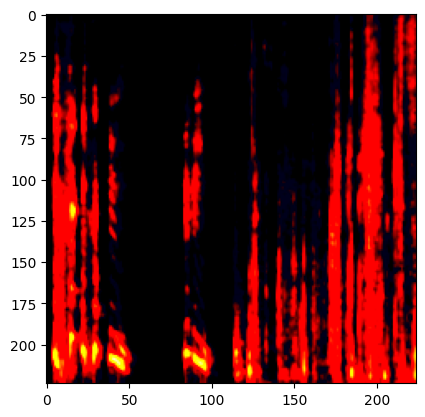

In [ ]:
import matplotlib.pyplot as plt
from random import randint

# Assuming train_loader is your DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Choose an image to display (e.g., the first image)

image = images[randint(0, len(images)-1)]

# Convert the tensor to a NumPy array and remove the channel dimension
# if it is a grayscale image
if len(image.shape) == 3 and image.shape[0] == 1:
    image = image.squeeze(0).numpy()
else:
    image = image.numpy().transpose((1, 2, 0))  # Transpose for RGB images


# Display the image using matplotlib
plt.imshow(image)
plt.show()


# Model

In [ ]:
class CNNModel(nn.Module):
    """A convolutional neural network model based on ResNet for spectrogram processing.

    Attributes:
        input_folder (str): Path to the input folder containing spectrograms.
        output_folder (str): Path to the folder where model outputs will be saved.
        resnet (torchvision.models.resnet.ResNet): The ResNet backbone used for feature extraction.
    """

    def __init__(self, dropout: float = 0.0):
        """Initializes the CNNModel.
        """
        super(CNNModel, self).__init__()
        self.resnet = models.resnet18(weights='IMAGENET1K_V1')
        num_features = self.resnet.fc.in_features  # Get input size of original FC layer

        # Remove the last FC layer and replace it with a binary classifier
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout),  # Apply dropout before the first layer
            nn.Linear(num_features, 1)  # Binary classification output
        )

        # Initialize weights and biases for the new FC layer
        self.resnet.fc[1].weight.data.normal_(mean=0.0, std=0.01)
        self.resnet.fc[1].bias.data.zero_()

        # Freeze all the pre-trained layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Selectively unfreeze some layers
        # for m in self.resnet.modules():
        #     if isinstance(m, nn.BatchNorm2d):
        #         m.requires_grad = True  # Ensure BatchNorm is updating

        for param in self.resnet.layer2.parameters():
            param.requires_grad = True

        for param in self.resnet.layer3.parameters():
            param.requires_grad = True

        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.fc.parameters():
            param.requires_grad = True


    def forward(self, spectrogram: torch.Tensor) -> torch.Tensor:
        """Defines the forward pass for the model.

        Args:
            spectrogram (torch.Tensor): Input tensor representing the spectrogram.

        Returns:
            torch.Tensor: The model's output after processing the spectrogram.
        """
        return self.resnet(spectrogram)

    def check_frozen_layers(self):
        for name, param in self.resnet.named_parameters():
            print(f"{name}: requires_grad = {param.requires_grad}")


# Training

In [ ]:
import torch.optim as opt

# Static hyperparameters
EPOCHS = 20

# Model parameters
DROPOUT = 0.6
MODEL = CNNModel(DROPOUT)

# Training
LOSS_FN = nn.BCEWithLogitsLoss()
WEIGHT_DECAY = 1e-4
MOMENTUM = 0.9
# OPTIMIZER = opt.Adam(params=MODEL.parameters(), lr=0.001)
OPTIMIZER = opt.SGD([{'params': MODEL.resnet.layer2.parameters(), 'lr': 1e-6},
                      {'params': MODEL.resnet.layer3.parameters(), 'lr': 1e-5},
                      {'params': MODEL.resnet.layer4.parameters(), 'lr': 1e-4},
                      {'params': MODEL.resnet.fc.parameters(), 'lr': 1e-3},
                      ], lr=1e-3, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Learning rate (you may need to go to ModelHandler.train() and modify the lr_scheduler.step() arguments)
STEPS_PER_LR_DECAY = 10
LR_DECAY = 0.1
LR_SCHEDULER = opt.lr_scheduler.StepLR(optimizer=OPTIMIZER, step_size=STEPS_PER_LR_DECAY, gamma=LR_DECAY)
# LR_SCHEDULER = None

torch.cuda.empty_cache()

In [ ]:
# Train the model
training_results, validation_results = None, None
best_model = None
best_val_f1 = 0

# Hyperparameter Searching
# Add to this list if you want to tune hyperparameters. You may need to edit
# or move around some of the code.
hyperparameter_options = [
    {}
]

for hyperparams in hyperparameter_options:
    print(f"Using hyperparameters: {hyperparams}")

    # Create new ModelHandler for each hyperparameter set
    cnn_model = MODEL
    optimizer = OPTIMIZER
    loss_func = LOSS_FN
    lr_scheduler = LR_SCHEDULER

    model_handler = ModelHandler(model=cnn_model,
                                 models_dir="/content/drive/MyDrive/RespiraCheck/models",
                                 optimizer=optimizer,
                                 loss_function=loss_func,
                                 lr_scheduler=lr_scheduler)

    # Train model
    training_results, validation_results = model_handler.train(train_loader=train_loader,
                                                               val_loader=val_loader,
                                                               epochs=EPOCHS,
                                                               model_name=f"j1")

    # Perform validation on model with best F1 score
    model_handler.model.load_state_dict(model_handler.best_states["best_metric"])
    val_acc, val_loss, f1 = model_handler.validate(val_loader, hyperparams)

    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model = model_handler

# Final testing with the best model
if best_model:
    test_acc, test_f1 = best_model.evaluate(test_loader)

Using hyperparameters: {}
0:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.63601 | Metric - 0.63
VLoss - 0.65284 | VMetric - 0.33

1:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.60217 | Metric - 0.65
VLoss - 0.66828 | VMetric - 0.43

2:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.57482 | Metric - 0.67
VLoss - 0.66366 | VMetric - 0.47

3:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.56663 | Metric - 0.68
VLoss - 0.64860 | VMetric - 0.41

4:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.57014 | Metric - 0.67
VLoss - 0.64286 | VMetric - 0.42

5:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.55512 | Metric - 0.68
VLoss - 0.63885 | VMetric - 0.48

6:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.55504 | Metric - 0.68
VLoss - 0.63413 | VMetric - 0.39

7:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.53675 | Metric - 0.69
VLoss - 0.63411 | VMetric - 0.40

8:
LR: [1e-06, 1e-05, 0.0001, 0.001]
Loss - 0.52557 | Metric - 0.70
VLoss - 0.65635 | VMetric - 0.55

9:
LR: [1e-07, 1.0000000000000002e-06, 1e-05, 0.0001]
Lo

# Eval

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
image = images[0]
label = labels[0]

model = CNNModel()
model_handler = ModelHandler(model=model,
                             models_dir="/content/drive/MyDrive/RespiraCheck/models",
                             optimizer=OPTIMIZER,
                             loss_function=LOSS_FN,
                             lr_scheduler=LR_SCHEDULER)
print(label.item())
model_handler.predict(image, "model__2025-03-30 02:25:57.881323.pth")

1


1.0

In [ ]:
def validate(model_handler, val_loader):
      model_handler.model.eval()
      all_preds = []
      all_targets = []

      with torch.no_grad():
          for batch in val_loader:
              inputs, targets = batch
              inputs, targets = inputs.to(device), targets.to(device)  # Move to device
              outputs = model_handler.model(inputs)
              preds = torch.argmax(outputs, dim=1)

              all_preds.extend(preds.cpu().numpy())
              all_targets.extend(targets.cpu().numpy())

      val_acc = accuracy_score(all_targets, all_preds)
      val_f1 = f1_score(all_targets, all_preds, average="weighted")

      return val_acc, val_f1

In [ ]:
eval_model = CNNModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_handler = ModelHandler(model=eval_model,
                             models_dir="/content/drive/MyDrive/RespiraCheck/models",
                             optimizer=OPTIMIZER,
                             loss_function=LOSS_FN,
                             lr_scheduler=LR_SCHEDULER,
                             load_model="/content/drive/MyDrive/RespiraCheck/models/j1_default_2025-03-30 19:57:36.pth")
a = model_handler.validate(val_loader)
a = model_handler.evaluate(test_loader)

Model loaded from /content/drive/MyDrive/RespiraCheck/models/j1_default_2025-03-30 19:57:36.pth
F1 Manual: 0.33519553072625696 | TP: 60 | FP: 96 | FN: 142
Validation Accuracy: 72.07% | Validation Loss: 0.5838 | F1 Score: 0.3352
Test accuracy: 71.71% | Test F1-Score: 0.3335343434916975


In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    """
    Plots the learning curves of training and validation loss.

    Args:
        train_losses (list): List of training loss values per epoch.
        val_losses (list): List of validation loss values per epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='--')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


train_losses = training_results["loss"]
val_losses = validation_results["loss"]
plot_learning_curves(train_losses, val_losses)